# <center> [Adult salaries](https://archive.ics.uci.edu/ml/datasets/adult): Decission Tree
### <center>Predict whether income exceeds $50K/yr based on census data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn import impute
from sklearn import compose
from sklearn import pipeline

from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree            import DecisionTreeClassifier, plot_tree
from sklearn.metrics         import accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn.inspection      import permutation_importance, plot_partial_dependence

from dtreeviz.trees import *

print(sklearn.__version__)

0.23.2


# Leer CSV

In [2]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
#!wget -P ./../data/ https://raw.githubusercontent.com/SaturdaysAI-Murcia/machine-learning/master/data/adult.csv

In [3]:
df = pd.read_csv("../data/adult.csv")

In [4]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# Qué queremos predecir? -> `df.salary`

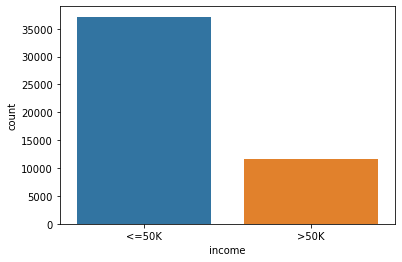

In [5]:
sb.countplot(df.income);

In [6]:
le = preprocessing.LabelEncoder()
df['income'] = le.fit_transform(df.income)

In [7]:
le.classes_

array(['<=50K', '>50K'], dtype=object)

# <center> Pre-processing
- Replace categories with their numeric codes
- handle missing continuous values
- Select target variable
- Split train and validation sets

# Missings

In [8]:
#df = df.dropna(axis='rows')

# Split Train (80%) and validation (20%) ¡STRATIFIED!

In [9]:
x = df.drop("income", axis="columns")
y = df["income"]

x_train, x_valid, y_train, y_valid = train_test_split(x, y,
                                                      test_size=0.2,
                                                      stratify=y, 
                                                      random_state=0)

# Tipos de variables

In [10]:
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income              int64
dtype: object

In [11]:
cat_vars   = list(x.select_dtypes(include=["category", "object", "bool"]).columns)
num_vars   = list(x.select_dtypes(exclude=["category", "object", "bool"]).columns)
target_var = y.name

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)
print("\nTarget variable:\n", target_var)


Numerical features:
 ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Categorical features:
 ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

Target variable:
 income


# Preprocesing: `OrdinalEncoder()` para las categorías

In [12]:
cat_preporcessing = pipeline.Pipeline(steps=[
    #('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', preprocessing.OrdinalEncoder())
])

preprocesador = compose.ColumnTransformer(transformers=[
  #  ('num', num_preprocessing, num_vars),
    ('cat', cat_preporcessing, cat_vars),
  # ('ord',    OrdinalEncoder(), num_feats),
], remainder='passthrough')

# Train Decission Tree

In [13]:
pipe = Pipeline([('prepro', preprocesador),
                 ('model', DecisionTreeClassifier(max_depth=3))])

pipe.fit(x_train, y_train)

Pipeline(steps=[('prepro',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country'])])),
                ('model', DecisionTreeClassifier(max_depth=3))])

In [14]:
x_train.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
1453,37,Private,71592,HS-grad,9,Never-married,Other-service,Other-relative,Asian-Pac-Islander,Female,0,0,17,United-States
30116,24,Private,190290,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States
16498,38,Private,182609,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,Poland
392,48,Local-gov,188741,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States
464,45,State-gov,226452,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States


In [15]:
x_train_prepro = pd.DataFrame(data=pipe["prepro"].transform(x_train),
                              columns=cat_vars+num_vars)
x_train_prepro.head()

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
0,4.0,11.0,4.0,8.0,2.0,1.0,0.0,39.0,37.0,71592.0,9.0,0.0,0.0,17.0
1,4.0,8.0,2.0,3.0,0.0,4.0,1.0,39.0,24.0,190290.0,11.0,0.0,0.0,45.0
2,4.0,9.0,2.0,12.0,0.0,4.0,1.0,31.0,38.0,182609.0,13.0,0.0,0.0,50.0
3,2.0,12.0,4.0,10.0,1.0,4.0,0.0,39.0,48.0,188741.0,14.0,0.0,0.0,50.0
4,7.0,11.0,2.0,8.0,0.0,4.0,1.0,39.0,45.0,226452.0,9.0,0.0,0.0,40.0


# Visualizar el árbol
- `sklearn.tree.export_text` -> FEA
- `sklearn.tree.plot_tree` -> REGULAR
- `dtreeviz` -> BONITA


In [16]:
print(tree.export_text(pipe["model"]))

|--- feature_4 <= 0.50
|   |--- feature_10 <= 12.50
|   |   |--- feature_11 <= 5095.50
|   |   |   |--- class: 0
|   |   |--- feature_11 >  5095.50
|   |   |   |--- class: 1
|   |--- feature_10 >  12.50
|   |   |--- feature_11 <= 5095.50
|   |   |   |--- class: 1
|   |   |--- feature_11 >  5095.50
|   |   |   |--- class: 1
|--- feature_4 >  0.50
|   |--- feature_11 <= 7055.50
|   |   |--- feature_4 <= 4.50
|   |   |   |--- class: 0
|   |   |--- feature_4 >  4.50
|   |   |   |--- class: 0
|   |--- feature_11 >  7055.50
|   |   |--- feature_8 <= 20.50
|   |   |   |--- class: 0
|   |   |--- feature_8 >  20.50
|   |   |   |--- class: 1



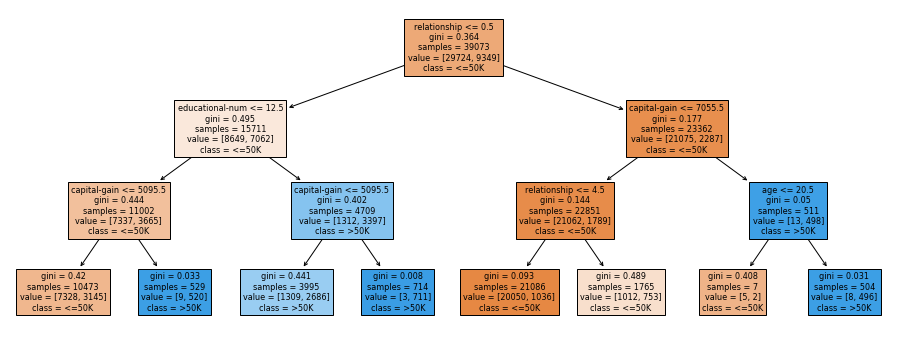

In [17]:
fig = plt.figure(figsize=(16,6))
_ = tree.plot_tree(pipe["model"], 
                   feature_names=list(x_train_prepro.columns),  
                   class_names=le.classes_, # {0:'<=50K', 1:'>50K'}
                   filled=True)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


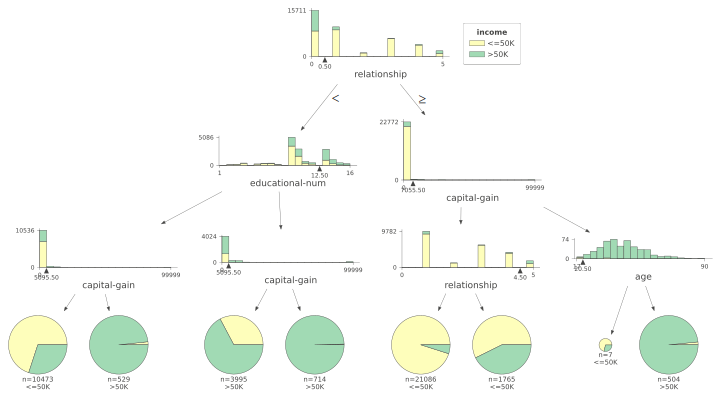

In [18]:
viz = dtreeviz(tree_model    = pipe["model"],
               x_data        = x_train_prepro,
               y_data        = y_train,
               feature_names = list(x_train_prepro.columns),
               target_name   = y.name,
               class_names   = list(le.classes_) # {0:'<=50K', 1:'>50K'}
   )

# viz.view() will give give a popup with graph in pdf
viz

# Use Decission Tree to prect new data

In [19]:
preds = pipe.predict(x_valid)
preds

array([0, 0, 0, ..., 0, 0, 1])

# Metrics

Accuracy (Caution): 83.96970007165524
Balanced accuracy:  71.62521085057521


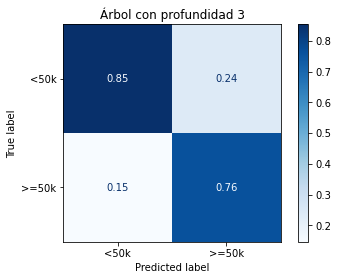

In [20]:
print("Accuracy (Caution):", accuracy_score(y_valid, preds)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_valid, preds)*100)
cm = plot_confusion_matrix(pipe, x_valid, y_valid, display_labels=["<50k", ">=50k"],
                      cmap=plt.cm.Blues, normalize="pred"); cm.ax_.set_title("Árbol con profundidad 3");

Accuracy (Caution): 85.52564233800798
Balanced accuracy:  74.28956321165846


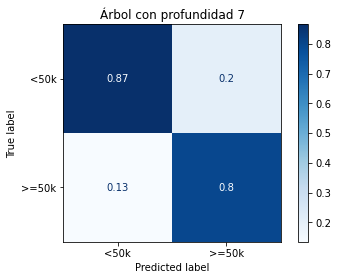

In [25]:
pipe = Pipeline([('prepro', preprocesador),
                 ('model', DecisionTreeClassifier(max_depth=7))])

pipe.fit(x_train, y_train)

print("Accuracy (Caution):", accuracy_score(y_valid, pipe.predict(x_valid))*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_valid, pipe.predict(x_valid))*100)
cm = plot_confusion_matrix(pipe, x_valid, y_valid, display_labels=["<50k", ">=50k"],
                      cmap=plt.cm.Blues, normalize="pred"); cm.ax_.set_title("Árbol con profundidad 7");

# Feature importance

In [22]:
sb.set()

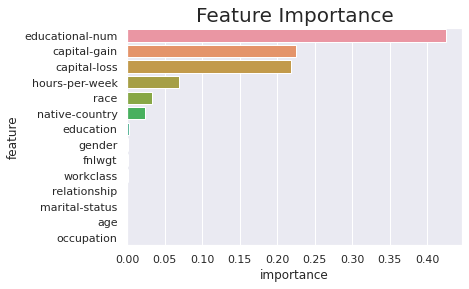

In [23]:
fi = pd.DataFrame({
      'feature':     x.columns,
      'importance':  pipe["model"].feature_importances_
     }).sort_values('importance', ascending=False).reset_index(drop=True)

sb.barplot(x=fi.importance, y=fi.feature).set_title("Feature Importance",  fontsize=20);

# [Permutation Feature Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html) (Better, but slower)
Otra forma de calcular las varaibles más importantes.

In [26]:
x_valid_prepro = pd.DataFrame(data=pipe["prepro"].transform(x_valid),
                              columns=cat_vars+num_vars)


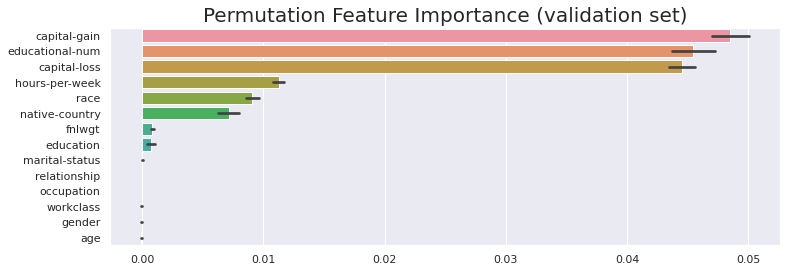

In [28]:
# Compute Permutation Feature Importance
pfi = permutation_importance(pipe["model"], x_valid_prepro, y_valid, n_repeats=10, random_state=0, n_jobs=-1)

# Clean data
sorted_idx = pfi.importances_mean.argsort()[::-1]
pfi_df = pd.DataFrame(data=pfi.importances[sorted_idx].T, columns=x_valid.columns[sorted_idx])

# Plot (This can be barplot, boxplot, violinplot,...)
plt.figure(figsize=(12,4))
sb.barplot(data=pfi_df, orient="h").set_title("Permutation Feature Importance (validation set)", fontsize=20);

# [Partial Dependence Plot](https://christophm.github.io/interpretable-ml-book/pdp.html)

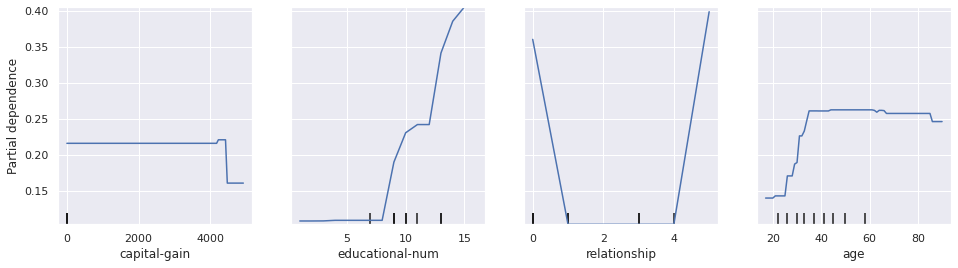

In [30]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_partial_dependence(estimator=pipe["model"],
                        X=x_train_prepro,          # raw predictors data.
                        features=["capital-gain", "educational-num", "relationship", "age"],
                        grid_resolution=100, # number of values to plot on x axis
                        n_cols=4,
                        ax=ax,
                        n_jobs=-1           # Faster with all CPU cores
                       );

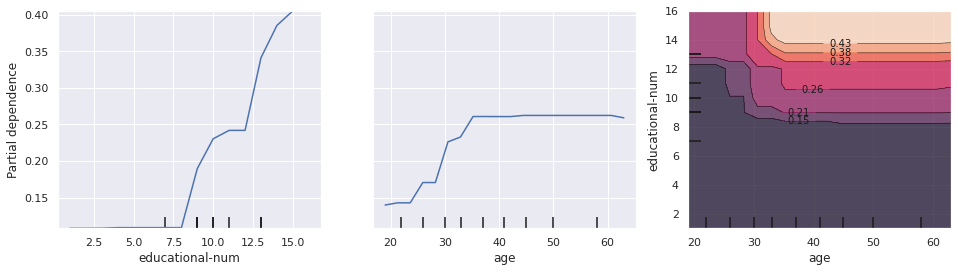

In [34]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_partial_dependence(estimator=pipe["model"],
                        X=x_train_prepro,
                        features=["educational-num", "age", ("age", "educational-num")],
                        grid_resolution=20,
                        ax=ax,
                        n_jobs=-1
                       );

# <center>FIN